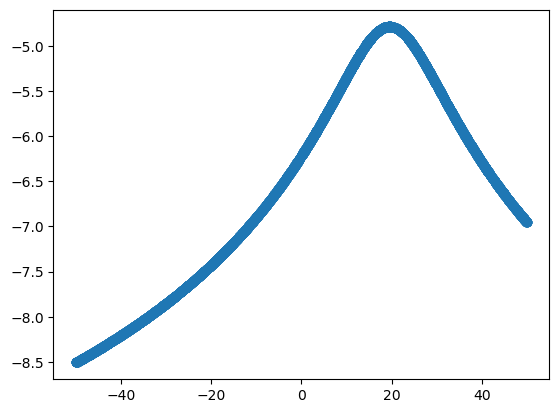

In [66]:

import pandas as pd
import numpy as np
import math
df = pd.read_csv("hw2_data.csv")

import matplotlib.pyplot as plt

plt.scatter(df['x'], df['y'])


class MLP_network:
    def __init__(self, node_config: list, activation_config: list):
        # node_config에는 Layer에 몇 개의 노드를 가질 것인지 나타낸다. 
        # Ex) [1, 2, 3, 3, 3, 1]
        # 5층에 각 층별로 1개, 2개, 3개, ... 1개씩 존재한다.
        self.node_configuration = node_config
        self.activation_config = activation_config
        # 각 노드에 하나씩 존재하도록 한다. 
        # 별도로 Bias는 Backpropagation 연산에는 포함되지 않도록 하며
        # 별도의 업데이트 과정을 거치도록 한다. 
        # 처음 학습을 시작할 때 별도로 bias_list를 초기화하는 과정을 거치도록 한다. 
        self.bias_list = list()

        # 3차원 큐브의 형태로 구성하고 있는 weight 정보
        # 한 Layer가 다른 layer로 전사될 때 하나의 Matrix가 사용된다. 
        # Bias는 별도로 업데이트 된다. 
        # 처음 학습을 시작할 때 별도로 weight_list를 초기화하는 과정을 거치도록 한다. 
        self.weight_list = list()

        # layer를 담도록 하는 list 객체
        # MLP 선언과 동시에 layer 정보가 담겨야 한다. 
        self.layers = []

        self.stack_delta_list = []

        return

        # 현재로써는 모든 노드가 identity를 activation 함수로 가지도록 한다. 
    # 추가적으로 activation 함수 또한 수정할 수 있도록 바꿔야 한다. 
    # 입력층에 값을 할당하는 것은 set_value 함수에서 하도록 한다.
    # Weight를 일괄적으로 initialization하는데 초점을 둔다. 
    # 별도로 Weight 외에, Bias 또한 일괄적으로 Update한다. 
    # 해당 함수를 사용해서, Matrix를 새로 초기화한다.
    def _configure_network(self):
        for index in range(len(self.node_configuration)):
            node_info = self.node_configuration[index]
            activation_info = self.activation_config[index]
            self.layers.append(Layer(node_info,activation_info))
        self.layers[0].is_first = True
        self.layers[-1].is_final = True
        for i in range(len(self.node_configuration)-1):
            # MLP에 초기 무직위 weight 정보 구성
            self.weight_list.append(np.random.rand(self.node_configuration[i+1], self.node_configuration[i]))
            self.bias_list.append(np.random.rand(self.node_configuration[i+1]))
            self.stack_delta_list.append(np.zeros((self.node_configuration[i+1], self.node_configuration[i])))
    def _refresh_stack_delta_list(self):
        for i in range(len(self.node_configuration)-1):
            self.stack_delta_list[i] = np.zeros((self.node_configuration[i+1], self.node_configuration[i]))
    # MLP 순전파 연산만 담당하도록 한다.
    # 입력 값을 넣는 과정은 set_value 함수가 담당하도록 한다. 
    # 여기에서는 단순하게 a 값을 반환하도록 한다.
    # 가중치 업데이트를 위한 a 값 획득은 training 단계에서 해결하도록 한다. 
    # 전파 과정은 다음 식으로 표현될 수 있다.
    # z = Wa + b
    # 순서가 다르다는 것에 유의하자.
    def forward_propagation(self):
        for i in range(len(self.node_configuration)-1):

            # 1차원 벡터 형식
            tempInput : np.ndarray = self.layers[i].a_vector

            # 2차원 행렬 형식
            tempWeight : np.ndarray = self.weight_list[i]

            # 1차원 벡터 형식 : 최종적으로 z_vector에 입력된다. 
            tempOutput : np.ndarray = np.zeros((1,self.node_configuration[i]))

            # 합산 z 구하는 과정
            tempOutput : np.ndarray = tempWeight @ tempInput



            # 노드 간 행렬곱 -> z 값 저장
            # Throw 발생으로 추정됨
            self.layers[i+1].z_vector = tempOutput + self.bias_list[i]
            #  -+> Activation Function 적용 호출
            self.layers[i+1].activation_function()
        return

        # backpropagation 가중치 update를 바라보고 알고리즘을 구성하는 것이 좋을 것 같음
    def backpropagation(self, y):

        # L 번째 Layer -+> L-1 번째 weight, Layer 
        self.layers[-1].delta_vector = self.layers[-1].a_vector - y

        # TO DO : 역전파 알고리즘에 적절하게 Range 메서드 인자 값 수정할 것
        for i in range(len(self.node_configuration)-2, 0, -1):
            # i - 1 Weight matrix와 연산해야 함
            # 전치된 행렬 얻음
            temp_weight_holder = self.weight_list[i].transpose()

            # delta 정보 전파
            self.layers[i].delta_vector = temp_weight_holder @ self.layers[i+1].delta_vector * self.layers[i].activation_diff()

            # wrong code for updating
            #self.layers[i].batch_delta_vector += self.layers[i].delta_vector

            # this is actually right code
            temp = np.outer(self.layers[i+1].delta_vector, self.layers[i].a_vector)
            self.stack_delta_list[i] = self.stack_delta_list[i] + temp
        return

    # batch iteration은 단순히 순전파, 역전파를 진행하고, 누적 delta 값을 하는데 초점을 맞춘다. 
    # batch 내의 데이터를 가지고 노는 역할
    def batch_iteration(self, data_set : pd.DataFrame, batch_size : int,learning_rate : float, bias_lambda : float):
        # 1회 Batch 실행할 때, 반드시 가중치 Matrix를 다시 초기화해야 한다.
        self._configure_network()

        for batch in np.array_split(data_set.sample(frac = 1), len(data_set) // batch_size):

            # iterate for every batch entity element 
            for index, row in batch.iterrows():
                self.set_value(row['x'])
                self.forward_propagation()

                #get error
                # 내 코드는 하나의 에러에 대해서만 Back-propagation을 수행하려고 함
                error = 0.5 * (self.layers[-1].a_vector - row['y'])**2
                print(f'x = {row["x"]} : label {row["y"]} : predict = {self.layers[-1].a_vector} : ERROR = {float(error)}')
                
                self.backpropagation(row['y'])

            # batch iteration end

            self.weight_update(batch_size, learning_rate, bias_lambda)
            #self.bias_update(batch_size, learning_rate)
            # soft reset for next batch
            for i in self.layers:
                i.delta_vector = None
                i.batch_delta_vector = 0
            self._refresh_stack_delta_list()
        return

        # batch_iteration 완료 후, 각 layer 별로 delta 값에 따라서 weight와 Bias를 Update한다
    def weight_update(self, batch_size : int,learning_rate : float, bias_lambda: float ):

        # 각 Layer를 역방향으로 탐색해오면서 누적 노드 Delta 값과 activation value를 곱한 Update Factor를 
        # learning Rate와 함께 곱하면서 weight와 Bias를 구한다.

        for i in range(len(self.weight_list)):
            D = (1/batch_size)*(self.stack_delta_list[i] + bias_lambda * self.weight_list[i])
            self.weight_list[i] = self.weight_list[i] - learning_rate * D

    # 해당 함수에서는 최종적으로 조정된 Parameter를 가지고 예측했을 때의 오차를 나타낸다.
    def validation(self, validation_data_set):
        total_error = 0
        total_samples = len(validation_data_set)
        for index, row in validation_data_set.iterrows():
            self.set_value(row['x'])
            self.forward_propagation()
            error = self.layers[-1].a_vector - row['y']
            total_error += error

        # cost function도 함수로 제공하면 좋을 듯
        mse = total_error / total_samples
        return mse

    # 단순히 입력층에 대해서만 값을 결정시킨다.
    # 출력층의 label은 별도로 Backpropagation과 validation, prediction에서 manual하게 다루게 한다.
    def set_value(self,x):
        self.layers[0].a_vector = np.array([x])

    # bias_list는 i + 1번째 layer가 i번째에 있음
    # 
    def bias_update(self,batch_size, learning_rate : float):
        for i in range(len(self.bias_list)):
            self.bias_list[i] = self.bias_list[i] - learning_rate * (1/batch_size) * self.layers[i+1].batch_delta_vector
    def just_prediction(self, input_data):
        self.set_value(input_data)
        self.forward_propagation()
        return self.layers[-1].a_vector[0]

class Layer:
    def __init__(self, num_nodes, diff: str, is_first:bool = False, is_final:bool=False):
        self.num_node = num_nodes
        self.z_vector : np.ndarray = None
        self.a_vector : np.ndarray = None
        self.delta_vector : np.ndarray = None
        self.batch_delta_vector = 0
        self._diff_info = diff
        self.is_final = False
        self.is_first = False

    def activation_function(self):
        if self._diff_info == 'sigmoid':
            self._sigmoid()
        elif self._diff_info == 'identity':
            self._identity()
        elif self._diff_info == 'tanh':
            self._tanh()

    def _sigmoid(self):
        self.a_vector = 1 / (1 + np.exp(-self.z_vector))

    def _identity(self):
        self.a_vector = self.z_vector
    
    def _tanh(self):
        self.a_vector = np.tanh(self.z_vector)
        
    def activation_diff(self):
        
        if self._diff_info == 'sigmoid':
            return (1 / (1 + np.exp(-self.z_vector))) * (1 - (1 / (1 + np.exp(-self.z_vector))))
        elif self._diff_info == 'identity':
            return 1
        elif self._diff_info == 'tanh':
            return 1 - np.tanh(self.z_vector) ** 2
        
    def clear_batch_delta_vector(self):
        self.batch_delta_vector = None
    


In [71]:
mlp = MLP_network([1,3,3,3,1], ['identity','identity','sigmoid','tanh','identity'])

base_data_set = pd.read_csv('hw2_data.csv')

training_data_set = base_data_set.sample(frac=1).reset_index(drop=True)

spliter = int(len(df) * 0.8)

training_data_set = base_data_set[:spliter]
validation_data_set = base_data_set[spliter:]

mlp.batch_iteration(training_data_set, 100,0.05,0)
print(mlp.validation(validation_data_set))
'''
x_values = np.linspace(df['x'].min(), df['x'].max(), len(df))  # 입력 데이터 생성
predicted_values = list()
print(mlp.just_prediction(20))
'''
x_values = np.linspace(df['x'].min(), df['x'].max(), len(df))  # 입력 데이터 생성
predicted_values = list()
for i in range(len(x_values)):
    temp = mlp.just_prediction(x_values[i])
    predicted_values.append(temp)
    


C:\Users\user\AppData\Local\Temp\ipykernel_67472\194924453.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f'x = {row["x"]} : label {row["y"]} : predict = {self.layers[-1].a_vector} : ERROR = {float(error)}')


x = -6.101123462 : label -6.653079164 : predict = [2.26539919] : ERROR = 39.76962804934313
x = 3.555239145 : label -5.924216756 : predict = [2.56285442] : ERROR = 36.01518854076019
x = -45.36026617 : label -8.372538247 : predict = [1.28842732] : ERROR = 46.66712780086674
x = 1.051878013 : label -6.131407353 : predict = [2.53289734] : ERROR = 37.53508787264228
x = 20.05844484 : label -4.788007115 : predict = [2.60041578] : ERROR = 27.294396450307133
x = 18.21860668 : label -4.799024722 : predict = [2.59975565] : ERROR = 27.3709755282678
x = -0.129822622 : label -6.224716706 : predict = [2.51095766] : ERROR = 38.15600327575162
x = -33.70437733 : label -7.989714935 : predict = [1.30743393] : ERROR = 43.218488513473
x = -31.0077231 : label -7.890125878 : predict = [1.31922325] : ERROR = 42.40605567788897
x = -5.06997706 : label -6.584009005 : predict = [2.32640432] : ERROR = 39.69773281955495
x = -6.374022183 : label -6.671038811 : predict = [2.24809208] : ERROR = 39.77544795984816
x = 46.

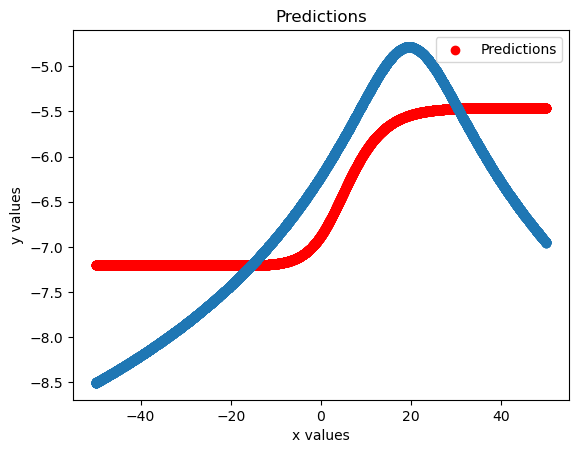

In [73]:
plt.scatter(x_values, predicted_values, label='Predictions', color='red')
plt.scatter(base_data_set['x'], base_data_set['y'])
plt.xlabel('x values')
plt.ylabel('y values')
plt.title('Predictions')
plt.legend()
plt.show()